In [90]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
import time
import os
import pickle
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
import shap
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import (
    mean_squared_error,       # MSE
    mean_absolute_error,      # MAE
    r2_score,                 # R² Score (coefficient of determination)
    mean_absolute_percentage_error,  # MAPE
    mean_squared_log_error    # MSLE
)
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()


In [91]:
df = pd.read_csv(r"D:\Win-Factor98\mw_pw_profiles.csv",low_memory=False)
print(df.columns.tolist())

['player_id', 'match_id', 'gender', 'balls_per_over', 'start_date', 'series_name', 'match_type', 'name_x', 'runs_scored', 'player_out', 'balls_faced', 'fours_scored', 'sixes_scored', 'catches_taken', 'run_out_direct', 'run_out_throw', 'stumpings_done', 'out_kind', 'dot_balls_as_batsman', 'order_seen', 'balls_bowled', 'runs_conceded', 'wickets_taken', 'bowled_done', 'lbw_done', 'maidens', 'dot_balls_as_bowler', 'player_team', 'opposition_team', 'name_y', 'unique_name', 'key_bcci', 'key_bcci_2', 'key_bigbash', 'key_cricbuzz', 'key_cricheroes', 'key_crichq', 'key_cricinfo', 'key_cricinfo_2', 'key_cricinfo_3', 'key_cricingif', 'key_cricketarchive', 'key_cricketarchive_2', 'key_cricketworld', 'key_nvplay', 'key_nvplay_2', 'key_opta', 'key_opta_2', 'key_pulse', 'key_pulse_2', 'full_name', 'batting_style', 'bowling_style', 'playing_role', 'teams', 'fantasy_score_batting', 'fantasy_score_bowling', 'fantasy_score_total']


# Feature engineering

In [92]:
df.drop(['gender', 'balls_per_over', 'series_name', 'name_x', 'name_y', 'unique_name','key_bcci', 'key_bcci_2', 'key_bigbash', 'key_cricbuzz',
       'key_cricheroes', 'key_crichq', 'key_cricinfo', 'key_cricinfo_2',
       'key_cricinfo_3', 'key_cricingif', 'key_cricketarchive',
       'key_cricketarchive_2', 'key_cricketworld', 'key_nvplay',
       'key_nvplay_2', 'key_opta', 'key_opta_2', 'key_pulse', 'key_pulse_2',
       'full_name', 'batting_style', 'bowling_style', 'playing_role', 'teams', ], axis = 1, inplace = True)
df['all_rounder_score'] = (df['runs_scored']/90 + df['wickets_taken']*0.35)*20
df['fielding'] = (df['catches_taken'] * 5 + df['run_out_throw'] * 15 + df['run_out_direct'] * 4)
df['impact'] = (df['runs_scored'] - df['balls_faced'] + df['fours_scored']*2.5 + df['sixes_scored']*4)/9
df['impact2'] = (df['wickets_taken']*3 + df['dot_balls_as_bowler']*0.9 - df['runs_conceded']*1.4)

# LABEL ENCODING CATEROGICAL OR MULTI CLASS COLUMNS
label_encoder = LabelEncoder()

df['player_id'] = label_encoder.fit_transform(df['player_id'].fillna("Unknown"))
df['match_type'] = df['match_type'].fillna("Unknown")
df = pd.get_dummies(df, columns = ['match_type'], drop_first = True, dtype=int)

df['player_team'] = label_encoder.fit_transform(df['player_team'].fillna("Unknown"))
df['opposition_team'] = label_encoder.fit_transform(df['opposition_team'].fillna("Unknown"))

df

,player_id,match_id,start_date,runs_scored,player_out,balls_faced,fours_scored,sixes_scored,catches_taken,run_out_direct,...,fantasy_score_total,all_rounder_score,fielding,impact,impact2,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test
0,922,1158348,21-08-2018,10,1,30,1,0,1,0,...,17,2.222222,5,-1.944444,0.0,0,0,0,1,0
1,922,1182644,05-05-2019,8,1,18,1,0,0,0,...,7,1.777778,0,-0.833333,0.0,0,0,0,1,0
2,922,1275107,09-09-2021,1,0,5,0,0,0,0,...,5,0.222222,0,-0.444444,0.0,0,0,0,1,0
3,922,1275113,15-09-2021,0,0,0,0,0,0,0,...,4,0.000000,0,0.000000,0.0,0,0,0,1,0
4,922,1275125,14-09-2021,1,1,15,0,0,0,0,...,-1,0.222222,0,-1.555556,0.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,11770,1473475,20-04-2025,0,0,0,0,0,0,0,...,4,0.000000,0,0.000000,0.0,0,0,0,1,0
416708,11770,1473478,23-04-2025,0,0,0,0,0,1,0,...,12,0.000000,5,0.000000,0.0,0,0,0,1,0
416709,11770,1473482,27-04-2025,25,0,13,2,2,1,0,...,49,5.555556,5,2.777778,0.0,0,0,0,1,0
416710,11770,1473487,01-05-2025,0,0,0,0,0,0,0,...,4,0.000000,0,0.000000,0.0,0,0,0,1,0


In [93]:
print(df.columns.tolist())

['player_id', 'match_id', 'start_date', 'runs_scored', 'player_out', 'balls_faced', 'fours_scored', 'sixes_scored', 'catches_taken', 'run_out_direct', 'run_out_throw', 'stumpings_done', 'out_kind', 'dot_balls_as_batsman', 'order_seen', 'balls_bowled', 'runs_conceded', 'wickets_taken', 'bowled_done', 'lbw_done', 'maidens', 'dot_balls_as_bowler', 'player_team', 'opposition_team', 'fantasy_score_batting', 'fantasy_score_bowling', 'fantasy_score_total', 'all_rounder_score', 'fielding', 'impact', 'impact2', 'match_type_MDM', 'match_type_ODI', 'match_type_ODM', 'match_type_T20', 'match_type_Test']


# Splitting the dataset for training and testing purpose

In [94]:
def split(df,date):
    train = df[df['start_date']< pd.to_datetime(date)]
    test = df[df['start_date']>= pd.to_datetime(date)]
    return train,test

df['start_date'] = pd.to_datetime(df['start_date'])
df_train, df_test = split(df, pd.to_datetime('2024-12-01'))

df_train.sort_values(by='start_date')
df_test.sort_values(by='start_date')

df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

C:\Users\abhau\AppData\Local\Temp\ipykernel_41720\464633085.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['start_date'] = pd.to_datetime(df['start_date'])


# Generating rolling-window stats of past few games to analyze recent form

In [95]:
def rolling_stats(group):
    group = group.sort_values('start_date')

    balls_faced = group['balls_faced'].replace(0, np.nan).astype(float)
    balls_bowled = group['balls_bowled'].replace(0, np.nan).astype(float)

    group['SR_match'] = (group['runs_scored'] / balls_faced) * 100
    group['ECO_match'] = group['runs_conceded'] / (balls_bowled / 6)

    group['SR_match'] = group['SR_match'].replace([np.inf, -np.inf], np.nan).clip(upper=300).fillna(0)
    group['ECO_match'] = group['ECO_match'].replace([np.inf, -np.inf], np.nan).clip(upper=20).fillna(0)

    # EWM stats
    group['strike_rate_1'] = group['SR_match'].shift(1).rolling(window=1, min_periods=1).mean()
    group['strike_rate_5'] = group['SR_match'].shift(1).rolling(window=5, min_periods=2).mean()
    group['strike_rate_10'] = group['SR_match'].shift(1).rolling(window=10, min_periods=5).mean()

    group['economy_rate_1'] = group['ECO_match'].shift(1).rolling(window=1, min_periods=1).mean()
    group['economy_rate_5'] = group['ECO_match'].shift(1).rolling(window=5, min_periods=2).mean()
    group['economy_rate_10'] = group['ECO_match'].shift(1).rolling(window=10, min_periods=5).mean()

    group['fours_1'] = group['fours_scored'].shift(1).rolling(window=1, min_periods=1).sum()
    group['fours_5'] = group['fours_scored'].shift(1).rolling(window=5, min_periods=2).sum()
    group['fours_10'] = group['fours_scored'].shift(1).rolling(window=10, min_periods=5).sum()

    group['sixes_1'] = group['sixes_scored'].shift(1).rolling(window=1, min_periods=1).sum()
    group['sixes_5'] = group['sixes_scored'].shift(1).rolling(window=5, min_periods=2).sum()
    group['sixes_10'] = group['sixes_scored'].shift(1).rolling(window=10, min_periods=5).sum()

    group['AR_1'] = group['all_rounder_score'].shift(1).rolling(window=1, min_periods=1).mean() * 10
    group['AR_5'] = group['all_rounder_score'].shift(1).rolling(window=5, min_periods=1).mean() * 10
    group['AR_10'] = group['all_rounder_score'].shift(1).rolling(window=10, min_periods=1).mean() * 10

    group['fantasy_1'] = group['fantasy_score_total'].shift(1).rolling(window=1, min_periods=1).sum() * 1.3
    group['fantasy_5'] = group['fantasy_score_total'].shift(1).rolling(window=5, min_periods=2).sum() * 1.2
    group['fantasy_10'] = group['fantasy_score_total'].shift(1).rolling(window=10, min_periods=5).sum()
    group['fantasy_15'] = group['fantasy_score_total'].shift(1).rolling(window=15, min_periods=9).sum()

    group['runs_scored_5'] = group['runs_scored'].shift(1).rolling(window=5, min_periods=2).sum()
    group['runs_scored_10'] = group['runs_scored'].shift(1).rolling(window=10, min_periods=5).sum()

    group['wickets_taken_5'] = group['wickets_taken'].shift(1).rolling(window=5, min_periods=2).sum()
    group['wickets_taken_10'] = group['wickets_taken'].shift(1).rolling(window=10, min_periods=5).sum()

    return group

def player_features(data):
    feature_data = []

    for player_id, group in data.groupby(['player_id']):

        group = group.sort_values('start_date')
        group = rolling_stats(group)
        feature_data.append(group)

    result_df = pd.concat(feature_data)
    final_result_df = result_df.reset_index(drop=True)

    return result_df[['player_id', 'match_id','match_type', 'start_date', 'fantasy_score_total','fantasy_1', 'fantasy_5', 'fantasy_10',
        'strike_rate_1', 'strike_rate_5', 'strike_rate_10', 'fours_1', 'fours_5', 'fours_10',
        'sixes_1', 'sixes_5', 'sixes_10','fantasy_15',
        'economy_rate_1', 'economy_rate_5', 'economy_rate_10'
        'AR_1', 'AR_5', 'AR_10','runs_scored_5', 'runs_scored_10','wickets_taken_5', 'wickets_taken_10','order_seen']]


In [96]:
def get_features_all_players(df):
    df_feat = rolling_stats(df)

    # Fix infinite values
    df_feat.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Fill numeric columns only (avoid Categorical error)
    numeric_cols = df_feat.select_dtypes(include=['number']).columns
    df_feat[numeric_cols] = df_feat[numeric_cols].fillna(0)

    # Detect one-hot encoded match_type columns
    match_type_cols = [col for col in df_feat.columns if col.startswith("match_type_")]

    return df_feat[
        [ 'player_id','match_id', 'start_date',
         'strike_rate_1', 'strike_rate_5', 'strike_rate_10',
         'economy_rate_1', 'economy_rate_5', 'economy_rate_10',
         'fours_1', 'fours_5', 'fours_10', 'sixes_1', 'sixes_5', 'sixes_10',
         'AR_1', 'AR_5', 'AR_10', 'fantasy_1', 'fantasy_5', 'fantasy_10',
         'fantasy_score_total','fantasy_15',
         'runs_scored_5', 'runs_scored_10', 'wickets_taken_5', 'wickets_taken_10','order_seen']
        + match_type_cols
    ].reset_index(drop=True)


In [97]:
df_all_features = get_features_all_players(df)
# Now split AFTER rolling stats
df_train_features = df_all_features[df_all_features['start_date'] < '2024-12-01']
df_test_features = df_all_features[df_all_features['start_date'] >= '2024-12-01']


In [98]:
print(df_train_features['start_date'].dtype)

datetime64[ns]


In [99]:
df_all_features.head()

,player_id,match_id,start_date,strike_rate_1,strike_rate_5,strike_rate_10,economy_rate_1,economy_rate_5,economy_rate_10,fours_1,...,runs_scored_5,runs_scored_10,wickets_taken_5,wickets_taken_10,order_seen,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test
0,11182,63963,2001-12-19,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,7,0,0,0,0,1
1,10187,63963,2001-12-19,41.935484,0.000000,0.0,3.183673,0.000000,0.0,6.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,1
2,8394,63963,2001-12-19,66.666667,54.301075,0.0,0.000000,1.591837,0.0,2.0,...,51.0,0.0,0.0,0.0,0,0,0,0,0,1
3,5249,63963,2001-12-19,25.000000,44.534050,0.0,2.692913,1.958862,0.0,0.0,...,55.0,0.0,4.0,0.0,0,0,0,0,0,1
4,68,63963,2001-12-19,0.000000,33.400538,0.0,3.154639,2.257807,0.0,0.0,...,55.0,0.0,4.0,0.0,0,0,0,0,0,1


In [100]:
# 0. Ensure you're not modifying a slice — make proper copies first
df_train_features = df_train_features.copy()
df_test_features = df_test_features.copy()
# 1. Replace 0 with NaN for avoiding infinite while dividing
df['balls_faced'] = df['balls_faced'].replace(0, np.nan)
df['balls_bowled'] = df['balls_bowled'].replace(0, np.nan)

# 2. Fill NaNs and infs in `df_test_features` with 0
df_test_features.replace([np.inf, -np.inf], np.nan)
df_test_features.fillna(0,inplace=True)

# Creating Training and Testing data

In [101]:
df_train_features.sort_values(by='start_date')

,player_id,match_id,start_date,strike_rate_1,strike_rate_5,strike_rate_10,economy_rate_1,economy_rate_5,economy_rate_10,fours_1,...,runs_scored_5,runs_scored_10,wickets_taken_5,wickets_taken_10,order_seen,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test
0,11182,63963,2001-12-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,7,0,0,0,0,1
20,1860,63963,2001-12-19,0.000000,36.344477,39.295224,1.870588,0.574118,1.251004,0.0,...,126.0,389.0,4.0,8.0,0,0,0,0,0,1
19,10153,63963,2001-12-19,67.187500,45.435386,39.295224,0.000000,1.466667,1.063946,5.0,...,216.0,389.0,0.0,4.0,6,0,0,0,0,1
18,11344,63963,2001-12-19,39.534884,40.719690,35.956755,0.000000,1.466667,1.063946,1.0,...,231.0,394.0,0.0,4.0,3,0,0,0,0,1
17,10707,63963,2001-12-19,0.000000,34.812714,35.336600,0.000000,2.127891,1.335132,0.0,...,215.0,391.0,4.0,5.0,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395536,9671,1432227,2024-11-30,0.000000,29.772727,35.062887,5.142857,4.270661,3.318707,0.0,...,17.0,99.0,15.0,22.0,3,0,0,0,1,0
395535,9945,1462596,2024-11-30,0.000000,42.772727,35.062887,5.250000,3.242089,3.649876,0.0,...,43.0,99.0,13.0,21.0,0,0,0,0,1,0
395534,5601,1462596,2024-11-30,112.500000,53.050505,35.062887,1.931034,2.692089,3.124876,0.0,...,80.0,99.0,13.0,20.0,0,0,0,0,1,0
395554,10642,1458412,2024-11-30,77.777778,58.555556,56.829861,0.000000,2.976923,2.678216,0.0,...,24.0,127.0,0.0,3.0,3,0,1,0,0,0


In [102]:
df_test_features.sort_values(by='start_date')

,player_id,match_id,start_date,strike_rate_1,strike_rate_5,strike_rate_10,economy_rate_1,economy_rate_5,economy_rate_10,fours_1,...,runs_scored_5,runs_scored_10,wickets_taken_5,wickets_taken_10,order_seen,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test
395600,7054,1442688,2024-12-01,43.103448,71.481032,51.920806,0.000000,1.654680,1.891626,6.0,...,196.0,220.0,6.0,6.0,0,0,0,0,1,0
395624,1621,1444652,2024-12-01,0.000000,41.184211,57.908123,0.000000,3.960000,4.201000,0.0,...,37.0,127.0,3.0,10.0,0,0,0,0,1,0
395625,3844,1442688,2024-12-01,0.000000,33.684211,50.408123,5.666667,3.293333,4.767667,0.0,...,34.0,118.0,4.0,12.0,0,0,0,0,1,0
395626,10905,1444652,2024-12-01,0.000000,13.684211,39.455742,7.428571,3.579048,4.710524,0.0,...,13.0,49.0,4.0,10.0,6,0,0,0,1,0
395627,2008,1444652,2024-12-01,180.000000,49.684211,44.955742,0.000000,2.619048,4.710524,3.0,...,40.0,71.0,2.0,10.0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416664,1578,1462374,2025-05-20,171.428571,91.255411,76.241630,5.516129,6.206017,4.585865,9.0,...,66.0,181.0,8.0,8.0,2,0,0,1,0,0
416663,7111,1462374,2025-05-20,118.181818,56.969697,66.157596,7.813953,6.182791,4.034252,2.0,...,18.0,145.0,7.0,7.0,7,0,0,1,0,0
416662,10032,1462374,2025-05-20,166.666667,51.561181,54.339414,7.000000,4.620000,4.175934,1.0,...,77.0,132.0,7.0,7.0,8,0,0,1,0,0
416668,10220,1473500,2025-05-20,167.647059,98.760400,77.865048,0.000000,3.530885,4.856838,4.0,...,202.0,220.0,3.0,10.0,2,0,0,0,1,0


In [103]:
print(df_train_features.columns)
print(df_test_features.columns)

Index(['player_id', 'match_id', 'start_date', 'strike_rate_1', 'strike_rate_5',
       'strike_rate_10', 'economy_rate_1', 'economy_rate_5', 'economy_rate_10',
       'fours_1', 'fours_5', 'fours_10', 'sixes_1', 'sixes_5', 'sixes_10',
       'AR_1', 'AR_5', 'AR_10', 'fantasy_1', 'fantasy_5', 'fantasy_10',
       'fantasy_score_total', 'fantasy_15', 'runs_scored_5', 'runs_scored_10',
       'wickets_taken_5', 'wickets_taken_10', 'order_seen', 'match_type_MDM',
       'match_type_ODI', 'match_type_ODM', 'match_type_T20',
       'match_type_Test'],
      dtype='object')
Index(['player_id', 'match_id', 'start_date', 'strike_rate_1', 'strike_rate_5',
       'strike_rate_10', 'economy_rate_1', 'economy_rate_5', 'economy_rate_10',
       'fours_1', 'fours_5', 'fours_10', 'sixes_1', 'sixes_5', 'sixes_10',
       'AR_1', 'AR_5', 'AR_10', 'fantasy_1', 'fantasy_5', 'fantasy_10',
       'fantasy_score_total', 'fantasy_15', 'runs_scored_5', 'runs_scored_10',
       'wickets_taken_5', 'wickets_taken

In [104]:
df_train_features = df_train_features.reset_index(drop=True)
df_test_features = df_test_features.reset_index(drop=True)

In [105]:
X_train = df_train_features.drop(['fantasy_score_total', 'start_date','player_id','match_id','strike_rate_1', 'strike_rate_5', 'strike_rate_10', 'economy_rate_1',
       'economy_rate_5', 'economy_rate_10', 'fours_1', 'fours_5', 'fours_10','wickets_taken_5', 'wickets_taken_10', 'order_seen',
       'sixes_1', 'sixes_5', 'sixes_10'], axis = 1)
y_train = df_train_features['fantasy_score_total']

X_test = df_test_features.drop(['fantasy_score_total', 'start_date','player_id','match_id','strike_rate_1', 'strike_rate_5', 'strike_rate_10', 'economy_rate_1',
       'economy_rate_5', 'economy_rate_10', 'fours_1', 'fours_5', 'fours_10','wickets_taken_5', 'wickets_taken_10', 'order_seen',
       'sixes_1', 'sixes_5', 'sixes_10'], axis = 1)
y_test = df_test_features['fantasy_score_total']

## CORRELATION MATRIX OF TRAINING DATA

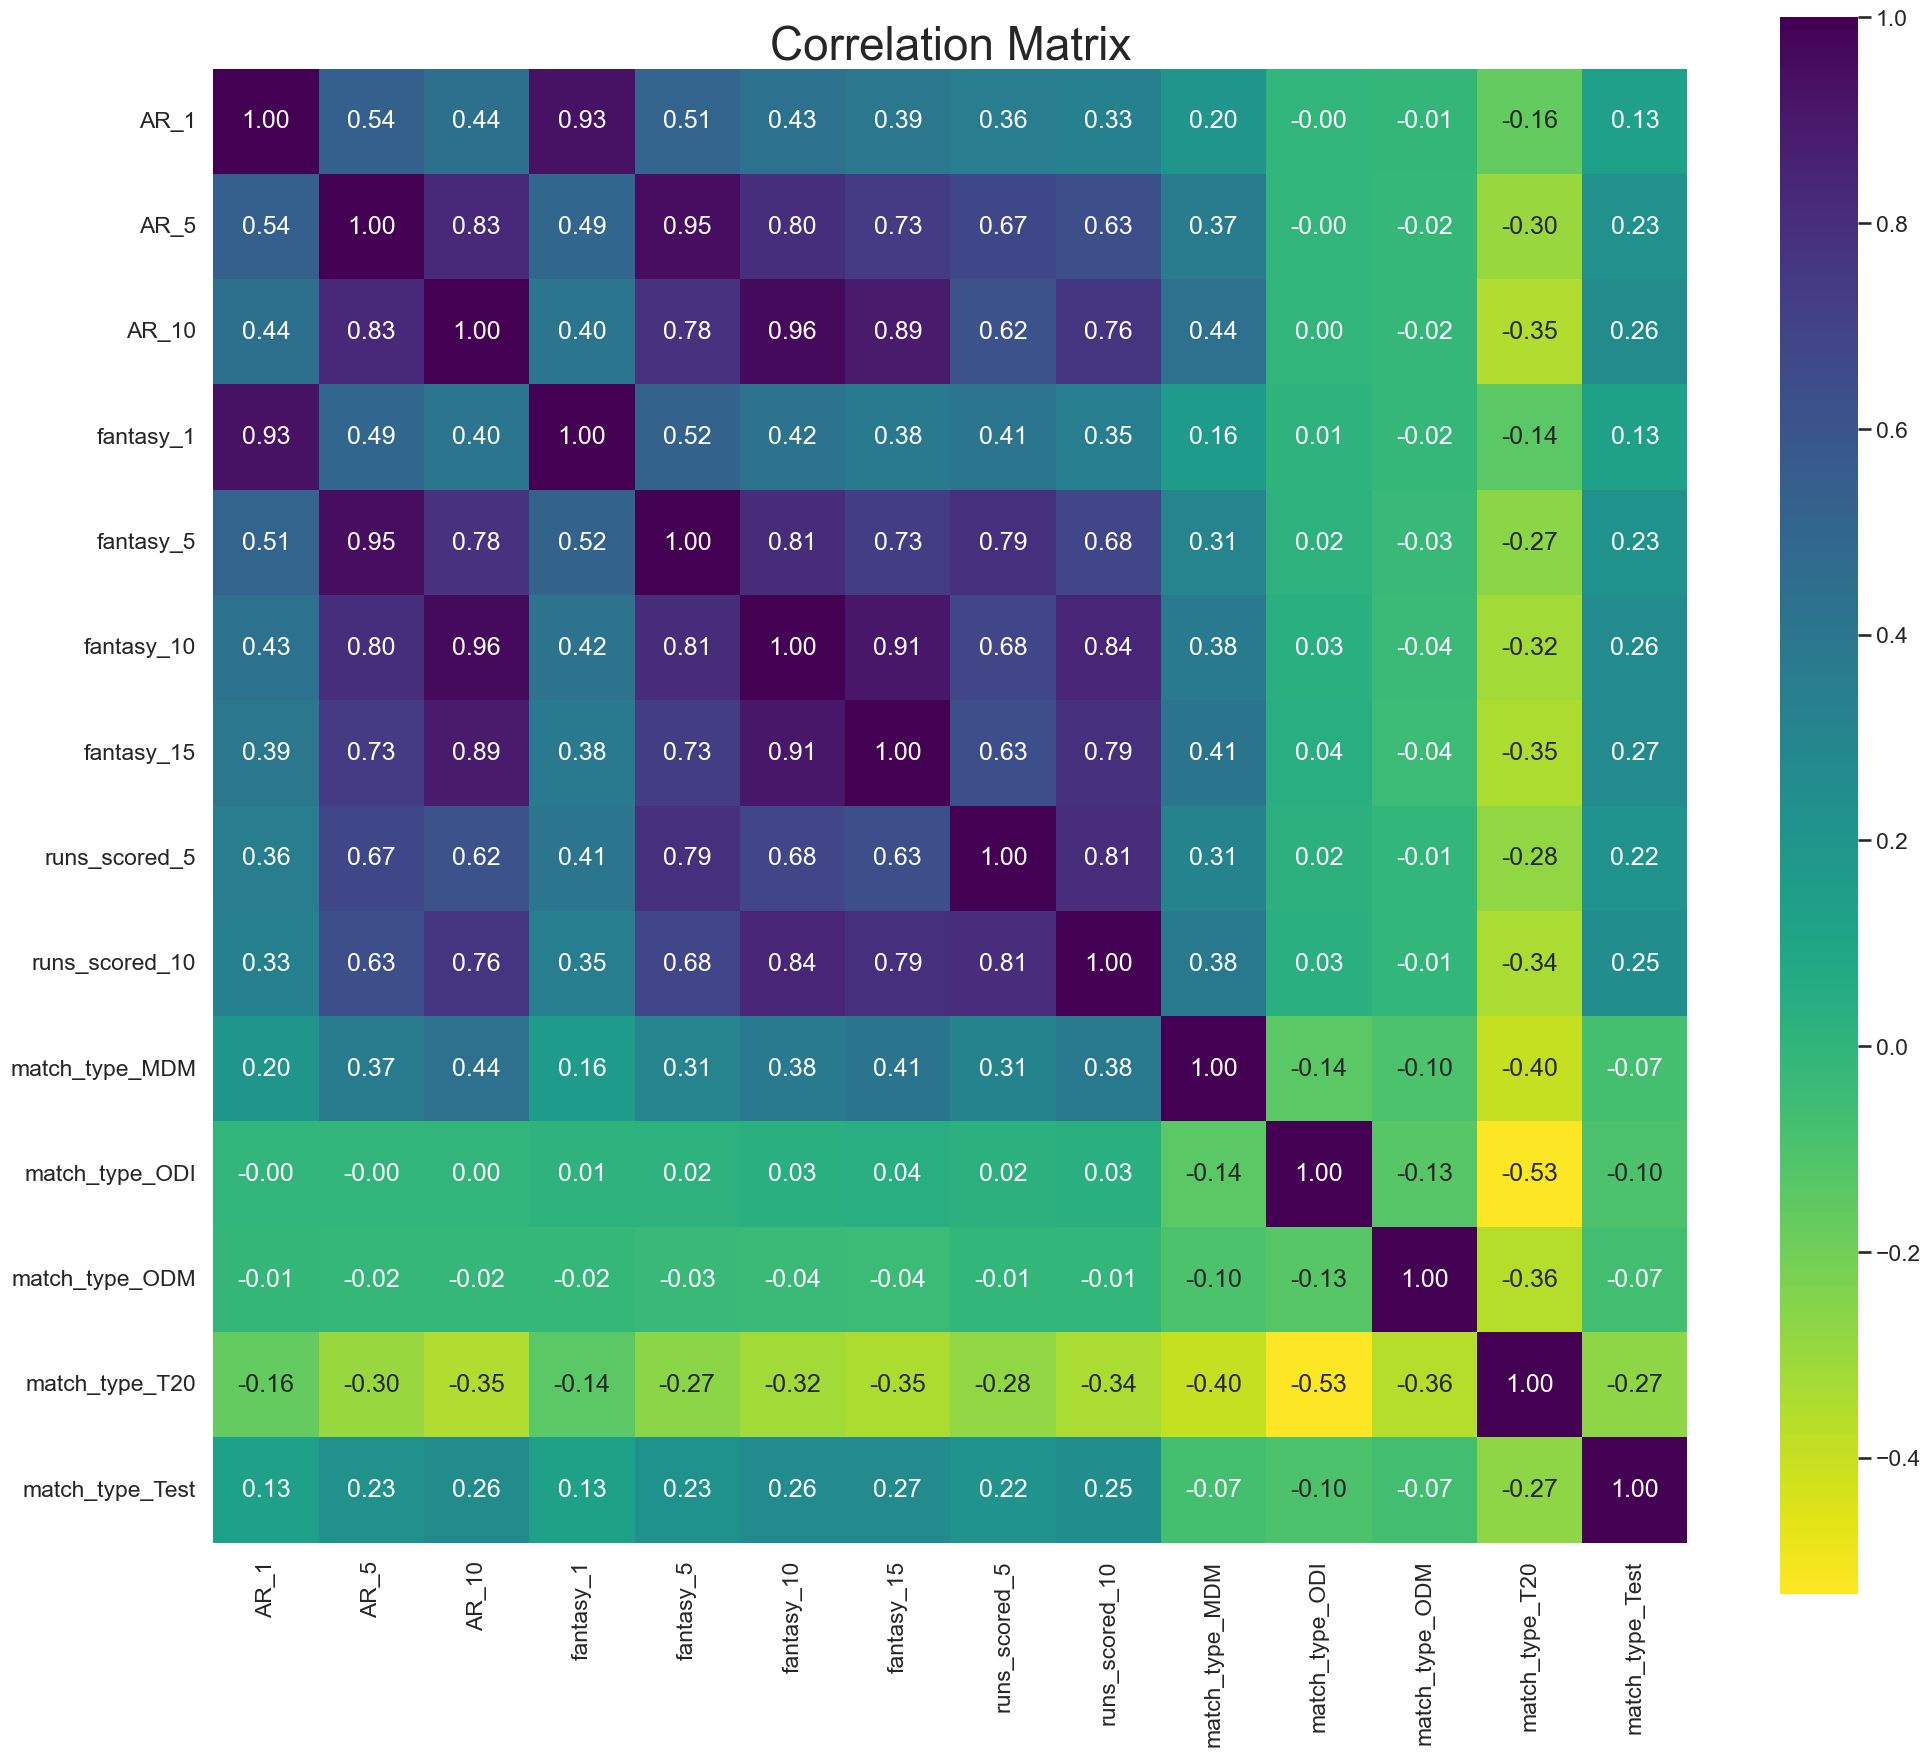

In [106]:
corr_matrix = X_train.corr()
plt.figure(figsize=(21, 18))
sns.heatmap(corr_matrix, annot=True, cmap='viridis_r', fmt='.2f', square=True)
plt.title("Correlation Matrix",fontsize=33)
plt.tight_layout()
plt.show()

In [107]:
X_test

,AR_1,AR_5,AR_10,fantasy_1,fantasy_5,fantasy_10,fantasy_15,runs_scored_5,runs_scored_10,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test
0,111.111111,171.111111,90.888889,93.6,492.0,481.0,736.0,196.0,220.0,0,0,0,1,0
1,70.000000,136.444444,97.888889,42.9,379.2,502.0,760.0,118.0,220.0,0,0,0,1,0
2,140.000000,88.222222,110.777778,91.0,313.2,562.0,826.0,104.0,215.0,0,0,0,1,0
3,83.333333,81.333333,115.555556,58.5,270.0,577.0,752.0,57.0,205.0,0,0,0,1,0
4,81.111111,97.111111,123.000000,55.9,315.6,605.0,731.0,61.0,207.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21107,70.000000,20.666667,34.222222,40.3,75.6,243.0,635.0,15.0,91.0,0,0,0,1,0
21108,8.888889,22.444444,28.111111,2.6,75.6,208.0,563.0,19.0,95.0,0,0,0,1,0
21109,0.000000,17.111111,21.222222,26.0,79.2,167.0,525.0,7.0,64.0,0,0,0,1,0
21110,0.000000,15.777778,13.222222,20.8,82.8,116.0,478.0,4.0,28.0,0,0,0,1,0


In [108]:
X_train 

,AR_1,AR_5,AR_10,fantasy_1,fantasy_5,fantasy_10,fantasy_15,runs_scored_5,runs_scored_10,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
1,86.666667,86.666667,86.666667,63.7,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1
2,26.666667,56.666667,56.666667,33.8,90.0,0.0,0.0,51.0,0.0,0,0,0,0,1
3,288.888889,134.074074,134.074074,109.2,190.8,0.0,0.0,55.0,0.0,0,0,0,0,1
4,0.000000,100.555556,100.555556,0.0,190.8,0.0,0.0,55.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395595,0.000000,10.666667,67.777778,5.2,85.2,326.0,679.0,24.0,116.0,0,0,0,0,1
395596,243.333333,59.333333,91.222222,165.1,223.2,444.0,702.0,102.0,190.0,0,0,0,0,1
395597,381.111111,133.333333,129.333333,162.5,361.2,565.0,769.0,111.0,204.0,0,0,0,1,0
395598,117.777778,149.777778,102.555556,105.3,422.4,527.0,732.0,148.0,241.0,0,0,0,1,0


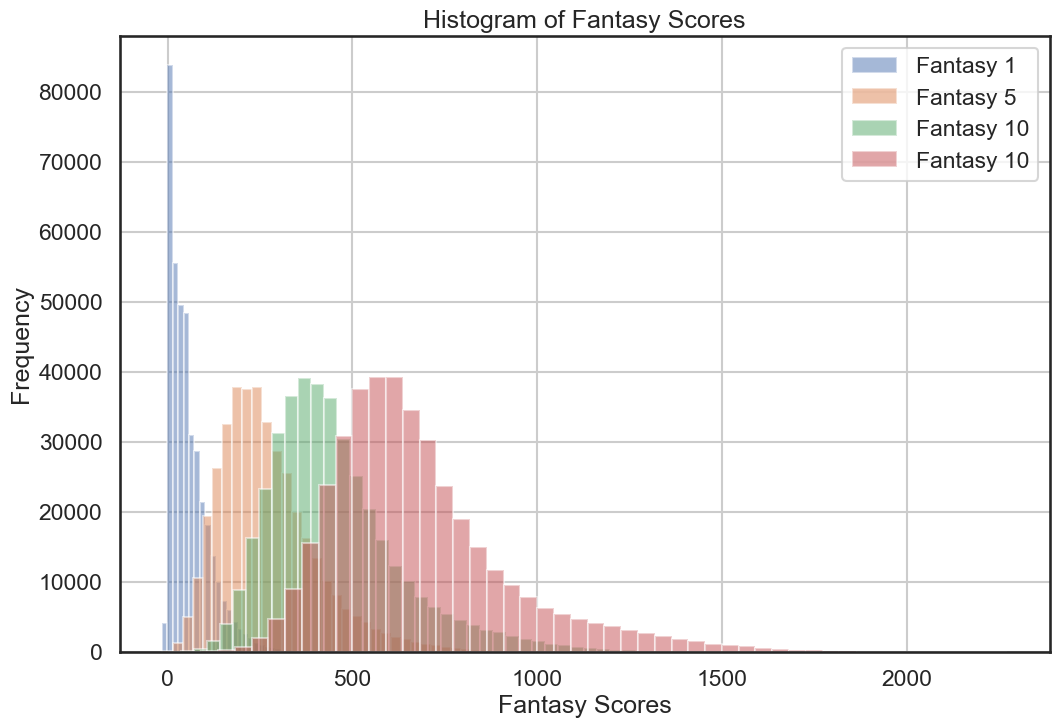

In [109]:
plt.figure(figsize=(12, 8))

plt.hist(X_train['fantasy_1'], bins=50, alpha=0.5, label='Fantasy 1')
plt.hist(X_train['fantasy_5'], bins=50, alpha=0.5, label='Fantasy 5')
plt.hist(X_train['fantasy_10'], bins=50, alpha=0.5, label='Fantasy 10')
plt.hist(X_train['fantasy_15'], bins=50, alpha=0.5, label='Fantasy 10')

plt.xlabel('Fantasy Scores')
plt.ylabel('Frequency')
plt.title('Histogram of Fantasy Scores')
plt.legend()
plt.grid(True)
plt.show()

In [110]:
X_train.columns

Index(['AR_1', 'AR_5', 'AR_10', 'fantasy_1', 'fantasy_5', 'fantasy_10',
       'fantasy_15', 'runs_scored_5', 'runs_scored_10', 'match_type_MDM',
       'match_type_ODI', 'match_type_ODM', 'match_type_T20',
       'match_type_Test'],
      dtype='object')

# Training on XG-BOOST MODEL

In [111]:
from xgboost import XGBRegressor
# Training the model
model = XGBRegressor(n_estimators=150, learning_rate=0.15, max_depth=15, random_state=42)
model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.15, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=150,
             n_jobs=None, num_parallel_tree=None, ...)

In [112]:
print(X_train.shape)

(395600, 14)


In [113]:
# Predict
fantasy_score_total_predicted = model.predict(X_test)

### PLOT OF ACTUAL VS PREDICTED FANTASY SCORE

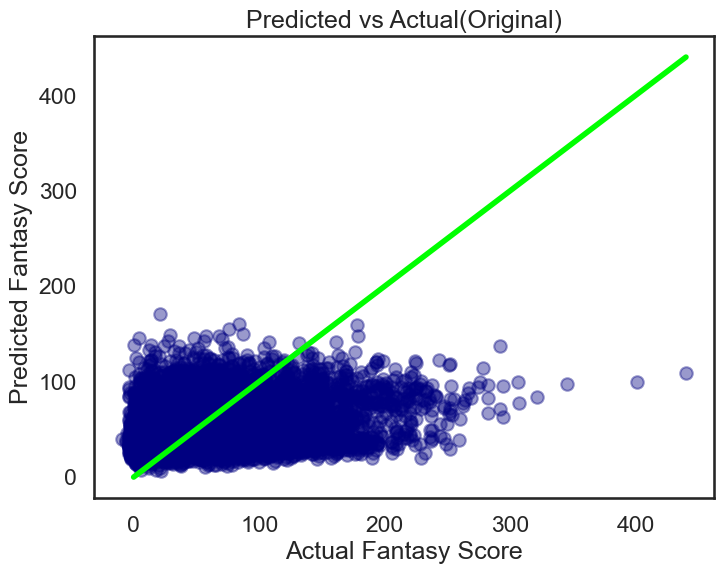

In [127]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, fantasy_score_total_predicted, alpha=0.4,color='navy')
plt.xlabel("Actual Fantasy Score")
plt.ylabel("Predicted Fantasy Score")
plt.title("Predicted vs Actual(Original)")
plt.plot([0, max(y_test)], [0, max(y_test)], color='lime',linewidth=4)  # perfect line
plt.show()


# Visualizing feature importance using shap

 97%|=================== | 292/300 [00:34<00:00]       

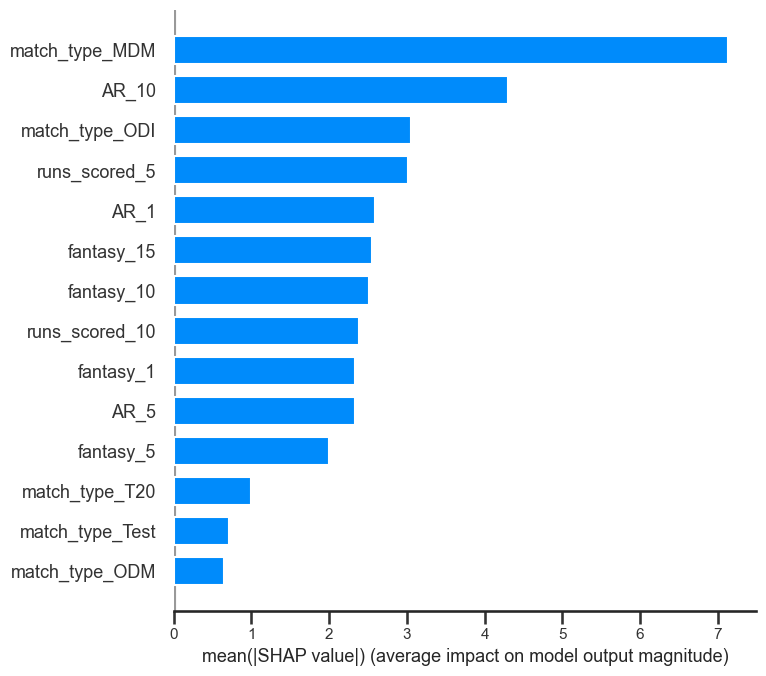

In [128]:
import shap
#Sampling 300 rows for saving time
X_sample = X_test.sample(n=300, random_state=42)

# SHAP explainer 
explainer = shap.Explainer(model, X_sample)
shap_values = explainer(X_sample)

# Plot bar chart of feature importance (mean |SHAP value|)
shap.summary_plot(shap_values, X_sample, plot_type='bar')


In [116]:
# Creating a DataFrame with actual and predicted fantasy_score_total
df_predictions = pd.DataFrame({
    'player_id': df_test_features['player_id'],
    'match_id': df_test_features['match_id'],
    'fantasy_score_total': df_test_features['fantasy_score_total'],
    'fantasy_score_total_predicted': fantasy_score_total_predicted
})
df_predictions.head()

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted
0,7054,1442688,33,40.585033
1,7873,1444652,70,32.857441
2,7055,1442688,45,37.513920
3,3430,1444652,43,29.203461
4,3041,1444652,61,41.006577


In [117]:
def mape_sum_top11_per_match(group):
    actual_top11_sum = group.nlargest(11, 'fantasy_score_total')['fantasy_score_total'].sum()
    predicted_top11_sum = group.nlargest(11, 'fantasy_score_total_predicted')['fantasy_score_total_predicted'].sum()
    
    # Avoid division by zero
    if actual_top11_sum == 0:
        return np.nan
    
    return abs(actual_top11_sum - predicted_top11_sum) / actual_top11_sum * 100
mape_by_match = df_predictions.groupby('match_id')[['fantasy_score_total', 'fantasy_score_total_predicted']].apply(mape_sum_top11_per_match)
mape = mape_by_match.mean()

In [118]:
print(f" MAPE: {mape:.2f} %")

 MAPE: 31.07 %


In [119]:
Top11_df = (
    df_predictions.groupby('match_id').apply(
        lambda x: pd.Series({
            'sum_top11_actual': x.nlargest(11, 'fantasy_score_total')['fantasy_score_total'].sum().round(0),
            'sum_top11_predict': x.nlargest(11, 'fantasy_score_total_predicted')['fantasy_score_total_predicted'].sum().round(0)
        })
    ).reset_index()
)
Top11_df['sum_top11_actual'] = Top11_df['sum_top11_actual'].astype(int)
Top11_df['sum_top11_predict'] = Top11_df['sum_top11_predict'].astype(int)


C:\Users\abhau\AppData\Local\Temp\ipykernel_41720\1313617572.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_predictions.groupby('match_id').apply(


In [ ]:
df_predictions # PREDICTIONS FOR INDIVIDUAL PLAYERS

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted
0,7054,1442688,33,40.585033
1,7873,1444652,70,32.857441
2,7055,1442688,45,37.513920
3,3430,1444652,43,29.203461
4,3041,1444652,61,41.006577
...,...,...,...,...
21107,3552,1485778,2,37.476486
21108,8689,1485778,20,45.680706
21109,11315,1485778,16,45.103058
21110,7468,1473500,0,25.844915


In [121]:
Top11_df

,match_id,sum_top11_actual,sum_top11_predict
0,1421074,832,588
1,1426556,1278,1081
2,1426557,1334,1143
3,1426558,1818,1098
4,1426559,1183,1154
...,...,...,...
946,1484052,762,471
947,1485778,649,469
948,1486225,846,474
949,1486227,688,428


# USING PARTICLE SWARM OPTIMIATION (PSO) TO MINIMIZE MAPE ACROSS TOP 11 TOTALS
 The objective function scales the predictions by a single weight factor

In [122]:
from pyswarm import pso
#function for pyswarm
def mape_PSO(w, df):
    scaled_pred = df['sum_top11_predict'] * w[0]
    mape = mean_absolute_percentage_error(df['sum_top11_actual'], scaled_pred)
    return mape * 100

# Wrapper to call PSO
# jUST UPPER AND LOWER BOUND FOR W
def run_pso(Top11_df, lower_bound=1.2, upper_bound=1.5):
    lb = [lower_bound]  
    ub = [upper_bound]  
    best_weight, best_score = pso(lambda w: mape_PSO(w, Top11_df), lb, ub, swarmsize=30, maxiter=40)
    print(f"\n Optimized weight: {best_weight[0]:.6f}, MAPE: {best_score:.2f} %")
    return best_weight[0], best_score

best_w, best_mape = run_pso(Top11_df)

Stopping search: Swarm best objective change less than 1e-08

 Optimized weight: 1.387846, MAPE: 17.64 %


### -->> AFTER USING PSO, MAPE REDUCED FROM 31 TO 17 WHICH IS A HUGE BOOST FOR THE MODEL

In [123]:
df_predictions['fantasy_score_total_predicted_scaled'] = (df_predictions['fantasy_score_total_predicted']* 1.387848).round(0).astype(int)
df_predictions['fantasy_score_total_predicted'] = (df_predictions['fantasy_score_total_predicted']).round(0).astype(int)
df_predictions.head(12)

,player_id,match_id,fantasy_score_total,fantasy_score_total_predicted,fantasy_score_total_predicted_scaled
0,7054,1442688,33,41,56
1,7873,1444652,70,33,46
2,7055,1442688,45,38,52
3,3430,1444652,43,29,41
4,3041,1444652,61,41,57
5,3727,1442688,7,40,56
6,8899,1442688,13,31,43
7,8587,1444652,83,34,47
8,10719,1444652,11,32,44
9,11419,1444652,31,26,36


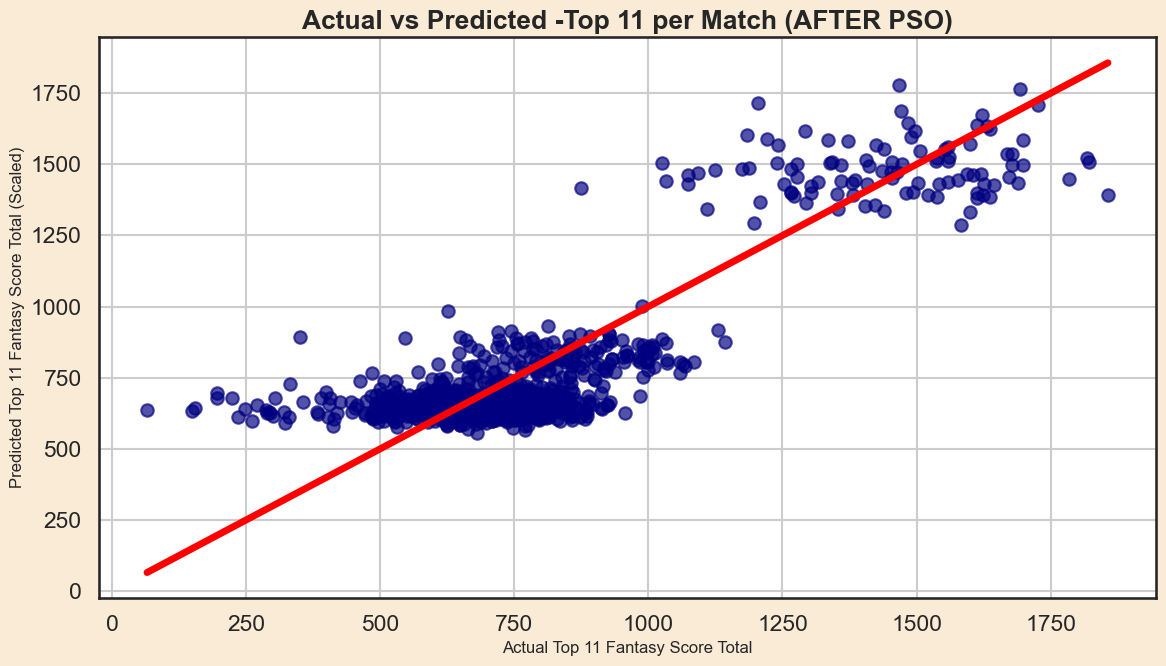

In [124]:
best_weight = 1.387848

Top11_df['sum_top11_predict_scaled'] = Top11_df['sum_top11_predict'] * best_weight

plt.figure(figsize=(12, 7),facecolor='antiquewhite')

plt.scatter(Top11_df['sum_top11_actual'], Top11_df['sum_top11_predict_scaled'], alpha=0.68, color='navy')
plt.plot([Top11_df['sum_top11_actual'].min(), Top11_df['sum_top11_actual'].max()],
         [Top11_df['sum_top11_actual'].min(), Top11_df['sum_top11_actual'].max()],color='red',linewidth=5)

plt.xlabel('Actual Top 11 Fantasy Score Total', fontsize=12)
plt.ylabel('Predicted Top 11 Fantasy Score Total (Scaled)', fontsize=12)
plt.title('Actual vs Predicted -Top 11 per Match (AFTER PSO)', fontsize=19,fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
match_type_cols = [col for col in df.columns if col.startswith("match_type_")]
print(match_type_cols)

['match_type_MDM', 'match_type_ODI', 'match_type_ODM', 'match_type_T20', 'match_type_Test']


In [ ]:
df_t20 = df[df['match_type_T20'] == 1].copy()
df_odi = df[df['match_type_ODI'] == 1].copy()
df_test = df[df['match_type_Test'] == 1].copy()
df_odm = df[df['match_type_ODM'] == 1].copy()
df_mdm = df[df['match_type_MDM'] == 1].copy()